In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets

# Load scientific and plotting libraries 
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from numpy.random import rand, random, randint, choice, normal, uniform 

## Umbrella Sampling

In [ ]:
from math import inf

def doMC_US(spins, N, J, B, T, w):
    ''' Attempt a flip of a randomly chosen spin at ij location of lattice''' 
    
    i, j = choice(N), choice(N)
    
    ##### Adding Umbrella potential 
    
    US=0  
    M=np.mean(spins)
    
    if M<w[0]:
        
        US=+100000
        
    elif M>w[1]:
        
        US=+100000
        
    #######
    
    deltaE = getDeltaE(spins, N, J, B, i, j)+US
    
    if deltaE < 0:
        '''For negative dE always accept'''
        spins[i,j] *= -1
            
    elif np.exp(-deltaE/T) > random():
        '''For positive dE distribute acceptance according to Boltzman dist'''
        spins[i,j] *= -1
    
    return spins

##  Simulated annealing

Monte Carlo technique for the **numerical optimization** of functions

Original paper: [S. Kirkpatrick, C. D. Gelatt, Jr., M. P. Vecchi, Science 220, 671-680 (1983)](http://science.sciencemag.org/content/220/4598/671.long)

Remember: it is difficult to find the **global** extremum of a function

Idea: Monte Carlo search of the function domain

Finding thermal ground state (energy minimum) of a statistical system $\leftrightarrow$ finding minimum (or similarly maximum) of any function

- introduce (artificial) temperature parameter $T$
- Metropolis algorithm with acceptance probability min$(1, e^{-\Delta f/T})$
- here $f$ can be any function we want to minimize (not only energy)
- for maximum simply change the sign: min$(1, e^{+\Delta f/T})$
- slowly reduce the temperature

This **slow cooling** is the main idea of simulated annealing

very high $T$                                |   very low $T$
---------------------------------------------|------------------------------------
almost all updates are accepted              | only updates that decrease the energy are accepted
random configurations/explore entire space   | descend towards minimum 
high energy                                  | low energy but might get stuck in local minimum
  
- if we slowly cool from high $T$ to low $T$ we will explore the entire space until we converge to the (hopefully) global minimum
- success is not guaranteed, but the methods works very well with good cooling schemes

Inspiration: annealing in metallurgy

This is a great method to tackle **NP-hard** optimization problems, such as the traveling salesman!

#### Cooling schedules

- slow cooling is essential: otherwise the system will "freeze" into a local minimum
- but too slow cooling is inefficient...
- initial temperature should be high enough so that the system is essentially random and equilibrates quickly
- final temperature should be small enough so that we are essentially in the ground state (system no longer changes)
- exponential **cooling schedule** is commonly used

  $$T(t)=T_0e^{-t/\tau},$$
  
  where $t$ is the Monte Carlo time and the constant $\tau$ needs to be determined (usually empirically)
  
- alternative cooling schedules:

  linear: $T(t)=T_0 - t/\tau$ (also widely used)
  
  logarithmic: $T(t) = c/\log(1+t/\tau)$

  
**Example:** global minimum of the function $f(x) = x^2 -\cos (4\pi x)$

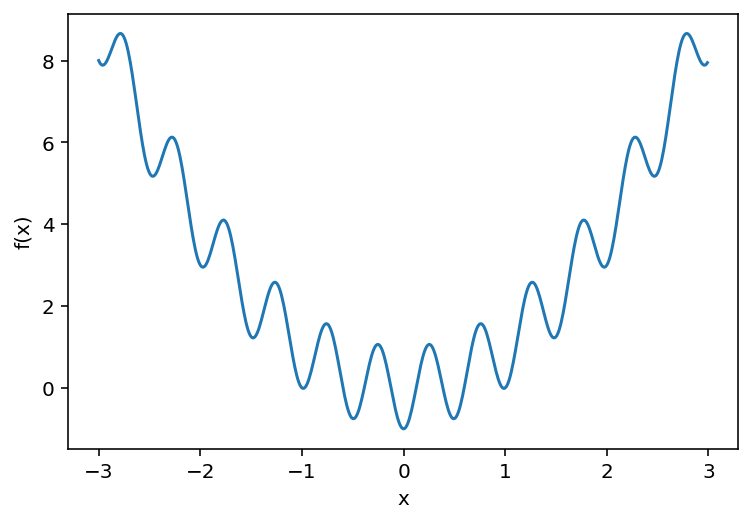

In [3]:
def f(x):
    return x*x - np.cos(4*np.pi*x)

xplot = np.arange(-3,3,0.01)
plt.plot(xplot, f(xplot))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()
# the global minimum is at x = 0

In [4]:
# global minimum search using simulated annealing

x = 2                 # start value for x
temperature = 10.0    # initial temperature
tempmin = 1e-4        # minimal temperature (stop annealing when this is reached)
cooltime = 1e4        # cooling time tau for exponential schedule
xlog = []             # list storing generated x-values
mean = 0              # parameter for MC update
sigma = 1             # parameter for MC update

# after every MC step we reduce the temperature
# alternatively we could only reduce it every N steps
def cool(temperature):
    return temperature*np.exp(-1/cooltime)

def MCupdate(x):
    # the new suggested x-value is the old one plus a Gaussian random number
    # this means we are trying to make a small step away from the old value
    xnew = x + np.random.normal(mean, sigma)
    
    # check if we accept the update -> Metropolis probability
    accept = False
    delta_f = f(xnew) - f(x)
    if delta_f < 0:
        accept = True
    else:
        prob = np.exp(-delta_f/temperature)
        if np.random.rand() < prob:
            accept = True
            
    if accept == True:
        x = xnew
        
    return x

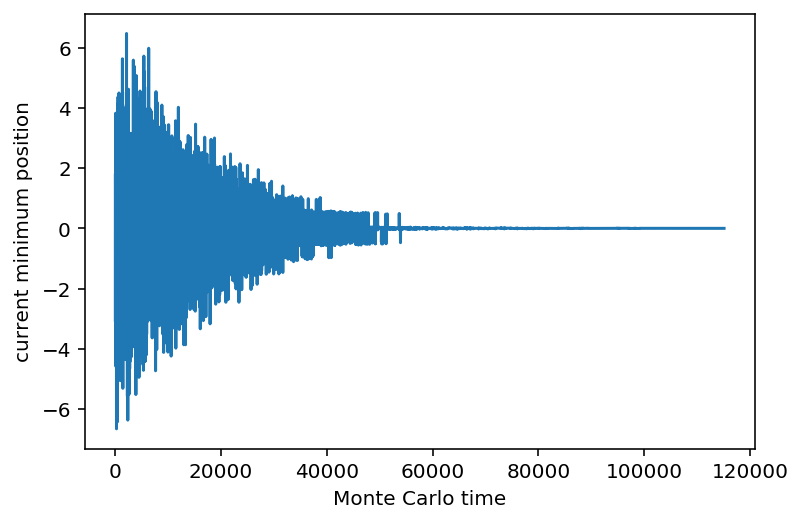

Final search result for the global minimum:  0.00045716369108088296


In [5]:
# main code for simulated annealing search

while temperature > tempmin:
    # update x-value with Metropolis algorithm
    x = MCupdate(x)
    # cool the system
    temperature = cool(temperature)
    # collect the x-value
    xlog.append(x)

# output results
plt.plot(xlog)
plt.xlabel('Monte Carlo time')
plt.ylabel('current minimum position')
plt.show()
print('Final search result for the global minimum: ', x)

In this example: minimum of a continuous function

- always slightly above true minimum if $T>0$

- best combined with a steepest descent method

In [6]:
# Set up simulated annealing for MCMC 2D Ising model

temperature = 10.0    # initial temperature
tempmin = 1e-4        # minimal temperature (stop annealing when this is reached)
cooltime = 1e4        # cooling time tau for exponential schedule

# how long it will take to cool to minimal temperature in MC steps
MCtime = -cooltime*np.log(tempmin/temperature)

# after every MC step we reduce the temperature
def cool(temperature):
    
    return temperature*np.exp(-1/cooltime)

### Parallel tempering

Simulated annealing is not guaranteed to find the global extremum (unless you cool infinitely slowly)

=> usually need to repeat search

Automate this: parallel tempering (also called **replica exchange Markov chain Monte Carlo**)

- simulate several copies of the system in parallel
- each copy is at a different constant temperature $T$
- usual Metropolis updates for each copy
- every certain number of steps attempt to exchange copies at neighboring temperatures
- exchange acceptance probability is min(1, $e^{-\Delta f\Delta\beta}$)
- if temperature difference small enough, the energy histograms of the copies will overlap


Advantages:

- exchanges allow to explore different extrema
- more successful for complex functions/energy landscapes
- they also ensure detailed balance (regular simulated annealing breaks detailed balance)

=> random walk in temperature space



**Temperature distributions:**

- a dense temperature grid increases the exchange acceptance rates...
- ...but takes longer to simulate and more steps are needed to move from one temperature to another
- there are many options, often trial and error is needed
     - exchange acceptance probability should be between about 20% and 80%
     - exchange acceptance probability should be approximately temperature-independent
     - commonly used: geometric progression
     
       $$T_n = T_{\rm min}\left(\frac{T_{\rm max}}{T_{\rm min}}\right)^{\frac{n-1}{N-1}}$$
       
       for $N$ temperatures $T_n$ between and including $T_{\rm min}$ and $T_{\rm max}$
       
       (ensures more steps around $T_{\rm min}$)
       
- make sure to spend enough time before swapping to achieve equilibrium

In [8]:
# Parallel tempering simulation of the Ising model ----------------------------------------

temperatureList = [5.0, 0.01, 0.0008, 0.0007, 0.00016, 0.00010]
numberCopies = len(temperatureList)